In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from experiments.model_evaluate.split_method import split_x_y, split_with_one_hot_encoding_function
from rbm.train.kfold_cross_validation import KFoldCrossValidation
from experiments.data.load_data_util import load_data, load_data_categories, load_small_data, load_small_data_categories
from sklearn.utils import shuffle
from experiments.model_evaluate.evaluate_method.evaluate_method import ScikitLearnClassifierModel, \
    ProbabilisticEvaluateMethod
from rbm.util.embedding import one_hot_encoding, k_hot_encoding

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [25, 4]#[14, 10]

import seaborn as sns
sns.set_style("whitegrid")


data = load_data('../data')
data = shuffle(data, random_state=42)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Plot position of expected element has been recommended in recommendation list

In [2]:
class PositionMethod(ProbabilisticEvaluateMethod):
    """
    Mean Reciprocal Rank
    """
    def evaluate_probabilistic(self, y, y_predicted, n_labels, **kwargs):
        positions = (- y_predicted).argsort()
        #positions = np.take_along_axis(positions, y.values.reshape((-1, 1)), axis=-1)
        _, positions = np.where(pd.DataFrame(positions) == y.values.reshape((-1, 1)))
        return positions.reshape((-1, ))

def evaluate_method(estimator, X, y):
    return PositionMethod().evaluate(estimator, X, y, 117)

def train(Model, params, data, split_method):
    kfolds = KFoldCrossValidation(data=data, n_splits=5, random_state=42, shuffle=False)

    model = Model(**params)
    ys = [{'train': [], 'test': []} for _ in range(6)]
    y_predicts = [{'train': [], 'test': []} for _ in range(6)]

    for index, train, test in kfolds.split():
        for column in range(0, 6):
            X, y = split_method(train, column)

            model.fit(X, y)
            X_test, y_test = split_method(test, column)

            ys[column]['train'].append(y)
            ys[column]['test'].append(y_test)
            
            y_predicts[column]['train'].append(evaluate_method(model, X, y))
            y_predicts[column]['test'].append(evaluate_method(model, X_test, y_test))

    return ys, y_predicts

y_expected, y_predicts = train(LogisticRegression, {}, data, split_with_one_hot_encoding_function(117))

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 

### In test subset

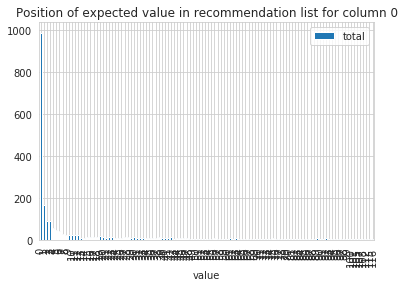

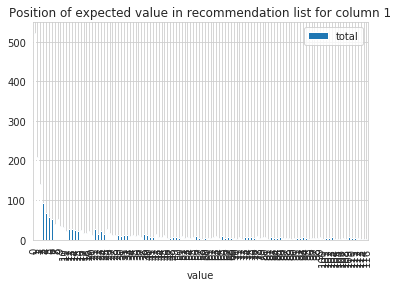

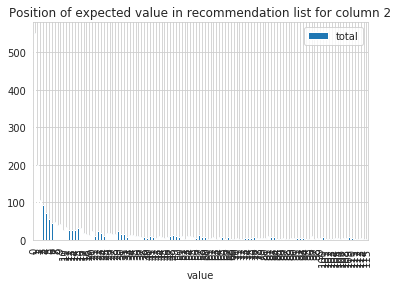

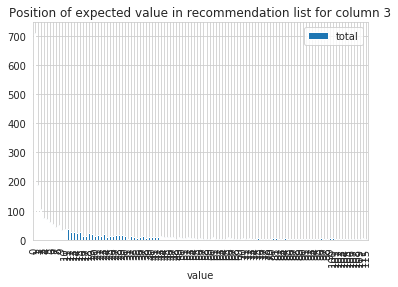

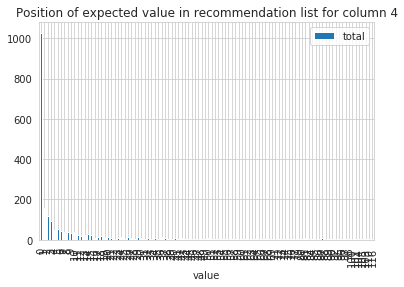

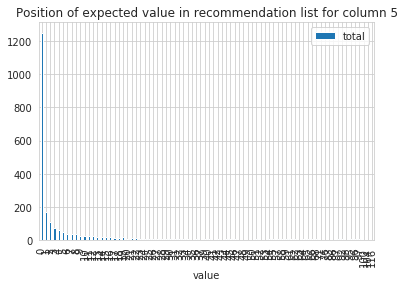

In [3]:
#positions = pd.DataFrame(np.concatenate(y_predicts[2]), columns=['value'])
for i in range(6):
    positions = pd.DataFrame(np.concatenate(y_predicts[i]['test']), columns=['value'])
    positions['total'] = 1
    total = positions.groupby('value').count()
    total.plot.bar(title=f'Position of expected value in recommendation list for column {i}')

total    0.389866
dtype: float64

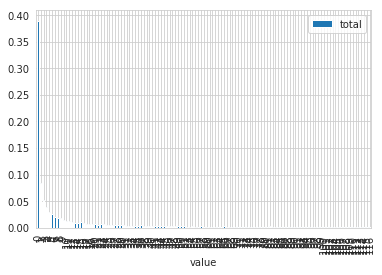

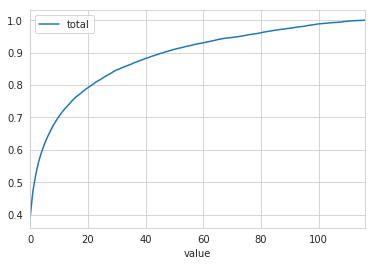

In [4]:
y_predicts_test = [y['test'] for y in y_predicts]
positions = pd.DataFrame(np.concatenate(np.concatenate(y_predicts_test)), columns=['value'])
positions['total'] = 1
total = positions.groupby('value').count()

with pd.plotting.plot_params.use('x_compat', True):
    (total / total.sum()).plot.bar()
    (total / total.sum()).cumsum().plot()

total.iloc[0] / total.sum()

### In train subset

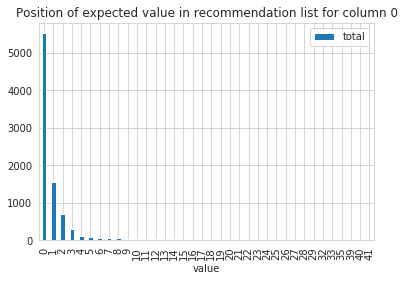

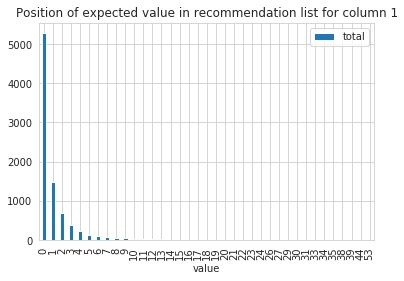

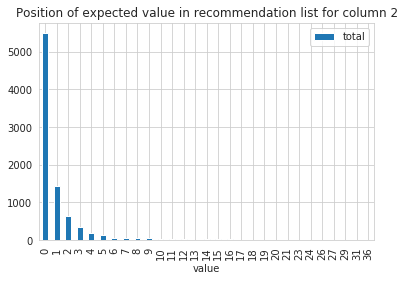

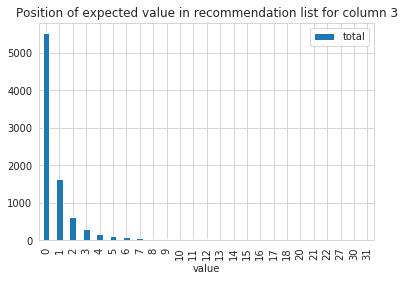

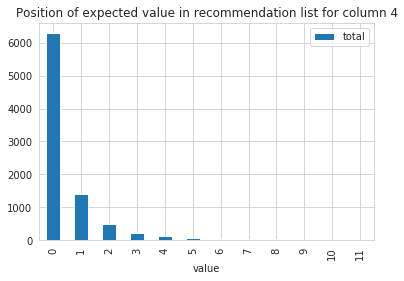

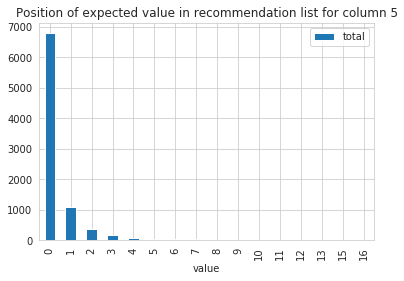

In [5]:
#positions = pd.DataFrame(np.concatenate(y_predicts[2]), columns=['value'])
for i in range(6):
    positions = pd.DataFrame(np.concatenate(y_predicts[i]['train']), columns=['value'])
    positions['total'] = 1
    total = positions.groupby('value').count()
    total.plot.bar(title=f'Position of expected value in recommendation list for column {i}')

total    0.673531
dtype: float64

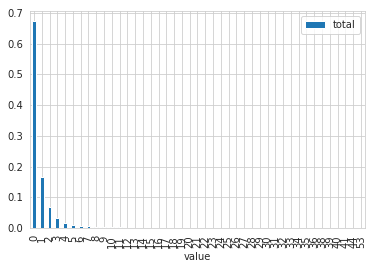

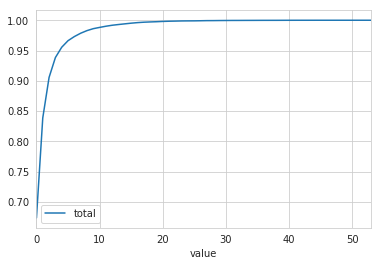

In [6]:
y_predicts_train = [y['train'] for y in y_predicts]
positions = pd.DataFrame(np.concatenate(np.concatenate(y_predicts_train)), columns=['value'])
positions['total'] = 1
total = positions.groupby('value').count()

with pd.plotting.plot_params.use('x_compat', True):
    (total / total.sum()).plot.bar()
    (total / total.sum()).cumsum().plot()

total.iloc[0] / total.sum()

# Grid search with distinct max steps

In [7]:
iters = list(range(8))

y_expecteds_list = []
y_predicts_list = []
for i in iters:
    y_expected, y_predicts = train(LogisticRegression, {'max_iter': i}, data, split_with_one_hot_encoding_function(117))
    
    y_expecteds_list.append(y_expected)
    y_predicts_list.append(y_predicts)

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs'

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number

Text(0, 0.5, 'Hit@1')

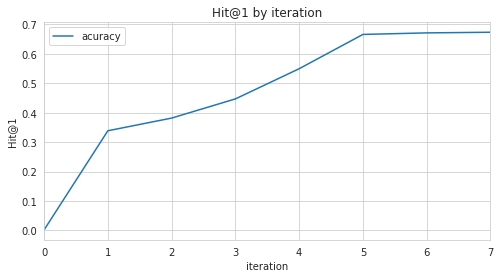

In [8]:
acuracy = []
for n_iterations, y_predicts in zip(iters, y_predicts_list):
    y_predicts_train = [y['train'] for y in y_predicts]
    positions = pd.DataFrame(np.concatenate(np.concatenate(y_predicts_train)), columns=['value'])
    positions['total'] = 1
    total = positions.groupby('value').count()

    acuracy.append((total.iloc[0] / total.sum()).values[0])

pd.DataFrame({'iteration': iters, 'acuracy': acuracy}).plot(x='iteration', figsize=(8,4), title='Hit@1 by iteration').set_ylabel('Hit@1')

# Plot probability

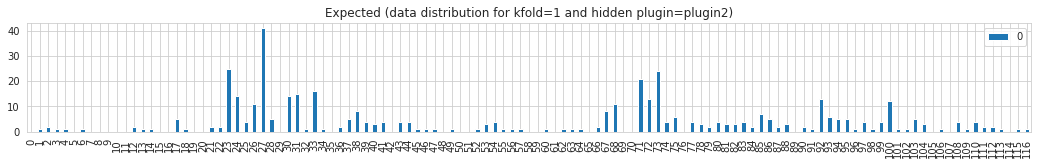

In [9]:
from rbm.util.embedding import one_hot_encoding

trained_fold = 1

kfolds = KFoldCrossValidation(data=data, n_splits=5, random_state=42, shuffle=False)
folds = list(kfolds.split())
index, train, test = folds[trained_fold]
y_column = 'plugin2'

X_train = train[['plugin1', 'plugin3', 'plugin4', 'plugin5', 'plugin6']]
y_train = train[[y_column]]

X = test[['plugin1', 'plugin3', 'plugin4', 'plugin5', 'plugin6']]
y = test[[y_column]]


data_distribution = {'data expected': one_hot_encoding(y.values, depth=117).sum(axis=0)}

pd.DataFrame(data_distribution['data expected']).plot.bar(figsize=(18, 2), title=f"Expected (data distribution for kfold=1 and hidden plugin={y_column})")

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-linux-x86_64.egg/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


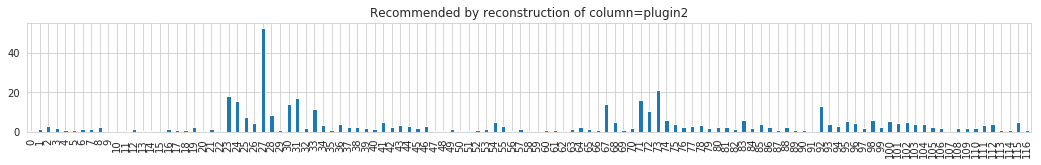

In [10]:
from experiments.model_evaluate.evaluate_method.evaluate_method import complete_missing_classes

model = LogisticRegression(multi_class='auto', solver='liblinear')
model.fit(X_train, y_train)

predict_proba = model.predict_proba(X)
predict_proba = complete_missing_classes(predict_proba, classes=model.classes_, n_expected_classes=117)

data_distribution['recommended'] = predict_proba.sum(axis=0)

pd.DataFrame(predict_proba).sum(axis=0).plot.bar(figsize=(18, 2), title=f"Recommended by reconstruction of column={y_column}")

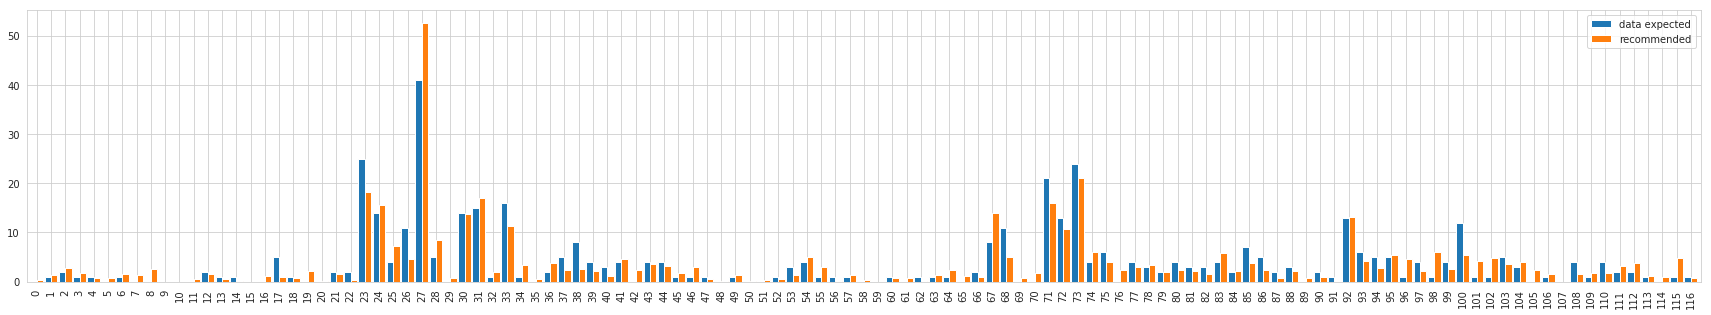

In [11]:
pd.DataFrame(data_distribution).plot.bar(figsize=(30, 5), width=.9)